<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


</h1><h1>Pre-Trained Models with PyTorch </h1>


In this notebook, we will use pre-trained model to classify between the negative and positive samples. The particular pre-trained model will be resnet18. We will change the output layer, then train the model. Lastly, we will identify several misclassified samples.

<h2>Table of Contents</h2>


1. Download Data
2. Imports and Auxiliary Functions 
3. Dataset Class
4. Question 1
5. Question 2
6. Question 3

<hr>

<h2 id="download_data">Download Data as TENSORS</h2>
<h4>Directly using tensors enables skipping the reshape, tensor conversion and normalization steps.</h4>

Download the dataset and unzip the files in your data directory, all the data will be deleted after closing the notebook, this may take some time:

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
!unzip -q Positive_tensors.zip 

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [1]:
# Install torchvision
!pip install torchvision

In [2]:
# Import libraries
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas
from PIL import Image

import time
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import h5py
import os
import glob
import skillsnetwork

# Enable replication of the work
torch.manual_seed(0)

## Download Data as IMAGES

Due to technical issue in my coding environment, I could not unzip tensor files. Therefore, I utilized jpeg images and transformations (see composed variable below).

In [3]:
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip",
                            path = "/resources/data", overwrite = True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../../../data'


<h2 id="data_class">Dataset Class</h2>


The dataset class is the same dataset we build in the previous notebook. 
*!!!(If you use tensor dataset you won't use the reshape, tensor conversion and normalization steps)*

In [4]:
# Create the dataset class

class Dataset(Dataset):

    def __init__(self, transform = None, train = True):
        directory = "/resources/data"
        positive = 'Positive'
        negative = 'Negative'

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        
        positive_files = [os.path.join(positive_file_path, file) for file
                          in os.listdir(positive_file_path) if file.endswith('.jpg')]
        positive_files.sort()
        
        negative_files = [os.path.join(negative_file_path, file) for file
                          in os.listdir(negative_file_path) if file.endswith('.jpg')]
        negative_files.sort()
        
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
        
        # The transform will be used on image
        self.transform = transform
        
        # torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print('Dataset class is ready to go!')

Dataset class is ready to go!


In [5]:
# Conduct transformations since data is in jpeg format

mean = [0.485, 0.456, 0.406] # Literature information
std = [0.229, 0.224, 0.225] # Literature information

composed = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [6]:
# Create training dataset object
train_dset = Dataset(transform = composed, train = True)

# Create validation dataset object
validation_dset = Dataset(transform = composed, train = False)

<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


In [7]:
# Step 1: Load the pre-trained model resnet18

model_resnet18 = models.resnet18(pretrained = True)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
# Step 2: Set the attribute requires_grad = False
# Thus, parameters cannot be trained for the pre-trained model

for param in model_resnet18.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs. Since previous hidden layer produced 512 outputs, our custom layer will receive 512 inputs. We want the our layer classify crack or not crack so its output will be 2.

In [9]:
# Step 3: Replace the output layer model.fc w/ nn.Linear object to classify 2 classes

model_resnet18.fc = nn.Linear(512, 2)

In [10]:
# Print out the model

print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In [11]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

In [12]:
# Step 2: Create training loader and validation loader object
train_loader = DataLoader(train_dset, batch_size = 100, shuffle = True)
validation_loader = DataLoader(validation_dset, batch_size = 100)

In [13]:
# Step 3: Create optimizer to minimize the loss

optimizer = torch.optim.Adam([parameters for parameters
                              in model_resnet18.parameters() if parameters.requires_grad],
                             lr = 0.001)

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [14]:
%%time

start_time = time.time()

n_epochs = 1
loss_list = []
accuracy_list = []

N_train = len(train_dset)
N_test = len(validation_dset)


def train(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model_resnet18 .train()
            optimizer.zero_grad()
            z = model_resnet18(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
        
        correct = 0
        for x_val, y_val in validation_loader:
            model_resnet18.eval() # set model to eval
            z = model_resnet18(x_val)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_val).sum().item()
        
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print('Training is done!!!')

train(n_epochs)

Training is done!!!
CPU times: user 45min 13s, sys: 17min 11s, total: 1h 2min 25s
Wall time: 1h 5min 29s


In [19]:
# Print out the accuracy

print(accuracy_list)

[0.9934]


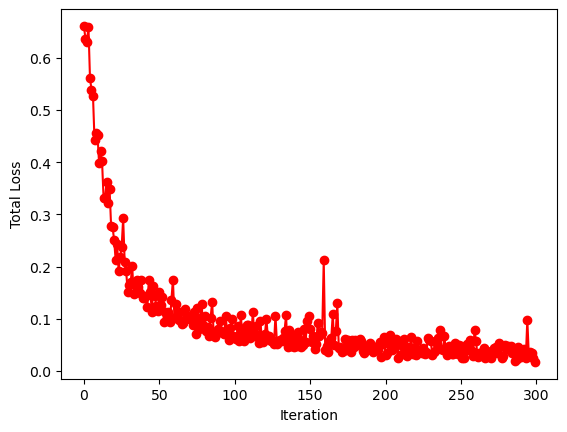

In [20]:
# Plot the loss stored in the list loss_list for every iteration

plt.plot(loss_list, '-ro', )
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.show()

<h2 id="Question_3">Question 3: Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [ ]:
incorrect = 0
for x_val, y_val in validation_loader:
    z = model_resnet18(x_val)
    _, yhat = torch.max(z.data, 1)
    incorrect += (yhat != y_val).sum().item()
print(incorrect)

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01&utm_medium=Exinfluencer&utm_term=10006555"> CLICK HERE </a> Click here to see how to share your notebook.


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
